In [607]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'DejaVu Sans', 'serif': ['Computer Modern'], 'size':15})
rc('text', usetex=True)
rc('figure', facecolor='w')
import astropy.io.fits as fits
import math, os
from natsort import natsorted

In [446]:
def mean(array):
    return np.sum(array)/len(array)

def stdev(array):
#     return np.sqrt(np.abs(mean(array)**2 - mean(array**2)))
    return np.sqrt(sum((array - mean(array))**2)/(len(array) - 1))

def median(array):
    percentile50 = int(np.round(len(array)/2))
   
    return sorted(array)[percentile50]

In [318]:
def factorial(n, **kwargs):
    
    method = kwargs.get('method')
    
    if method == 'exact':
        nfact = 1
        for i in range(n):
            nfact *= (i+1)
    else: # sterling approximation
        nfact = math.sqrt(2*math.pi) * n**(n+.5) / math.e**n
        
    return nfact

def poisson(xarray, mu):
    
    pdist = np.array([mu**x/factorial(x) * math.e**(-mu) for x in ])

710.078184642185

In [512]:
def readData(folder):
    """
    Read all frames from a given directory into one matrix.
    input:  directory to folder containing frames
    output: array3d (dimension: xpixel x ypixel x # frames)
            array2D (dimension: 1D flattened img x # frames)
    """
    
    files = os.listdir(folder)

    array3D, array2D = [], []
    for ff in files:
        arr = fits.getdata(folder + ff)
        array3D.append(arr)
        array2D.append(arr.flatten())
    
    return np.array(array3D)

def combineFrame(data_array):
    """
    Combine image frames and return 1D array.
    input:  data array (dimension: # 1D detector counts x # frames)
    output: 1D combined array of detector counts (ADU)
    """
    
    return np.median(data_array, axis=0)

def cutData(array, **kwargs):
    
    avg = mean(array)
    std = stdev(array)
    arr_rng = [min(array), max(array)]
    
    if 'sigma' in kwargs:
        sigma = kwargs.get('sigma')
        low = int(np.round((avg-sigma*std)))
        high = int(np.round((avg+sigma*std)))
        cut = kwargs.get('cut', [low, high])
    elif 'rng' in kwargs:
        cut = kwargs.get('rng')
    else:
        cut = kwargs.get('cut', arr_rng)
    pixel_keep = np.where((array > cut[0]) & (array < cut[1]))[0]
    
    cut_array = array[pixel_keep]
    per_rem = np.round((1 - len(cut_array)/len(array))*100,2)
    print('Cut from range %s to %s, removing %s percent of data points'%(arr_rng, cut, per_rem))
    
    return cut_array

In [549]:
def plotImg(arr, **kwargs):
    
    avg = mean(arr.flatten())
    std = stdev(arr.flatten())
    
    sigma = kwargs.get('sigma', 5)
    rng = kwargs.get('rng', [avg-sigma*std, avg+sigma*std])
    
    pl = plt.imshow(arr, origin='lower', interpolation='nearest', cmap='gray', vmin=rng[0], vmax=rng[1])
    if 'sigma' in kwargs: 
        plt.colorbar(pl).set_label('Detector Value %s-$\sigma$ scale (ADU)'%(sigma))
    else:
        plt.colorbar(pl).set_label('Detector Value (ADU)')
    plt.xlabel('pixels(x)')
    plt.ylabel('pixels(y)')
    plt.show()

def plotHist(arr, **kwargs):
    
    avg = mean(arr)
    std = stdev(arr)
    med = median(arr)
    
    sigma = kwargs.get('sigma', 5)
    low = int(np.round((avg-sigma*std)))
    high = int(np.round((avg+sigma*std)))
    rng = kwargs.get('rng', [low, high])
    exp = kwargs.get('exp')
    
    hr = np.arange(rng[0], rng[1])
    hist = []
    for i in hr:
        counts = len(np.where(arr==i)[0])
        hist.append(counts)
    plt.step(hr, hist, color='k')

    plt.axvline(avg, color='b', label=r'$\bar{x}=%s$'%(np.round(avg,2)))
    plt.axvline(med, color='b', label=r'$\tilde{x}=%s$'%(np.round(med,2)), linestyle='dashed')
    if kwargs.get('show_level', True) == True:
        for i in np.arange(1,sigma+1):
            if i == 1:
                plt.axvspan(avg-i*std, avg+i*std, facecolor='g', alpha=0.05, label=r'$\sigma=\pm %s$'%(np.round(std,2)))
            else:
                plt.axvspan(avg-i*std, avg+i*std, facecolor='g', alpha=0.05)
    
    plt.legend(loc='upper left')
    plt.xlabel('Counts (ADU)')
    plt.ylabel('Frequency')
    if 'exp' in kwargs:
        plt.title('Exposure Time: %s sec'%(exp))
    plt.xlim(rng)
    plt.show()

In [619]:
def plotAll(array2D, **kwargs):
    
    arr = array2D.flatten()
    avg = mean(arr)
    std = stdev(arr)
    med = median(arr)
    
    sigma = kwargs.get('sigma', 2)
    low = int(np.round((avg-sigma*std)))
    high = int(np.round((avg+sigma*std)))
    rng = kwargs.get('rng', [low, high])
    exp = kwargs.get('exp')
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=[16,6])
    
    # Histogram
    hr = np.arange(rng[0], rng[1])
    hist = []
    for i in hr:
        counts = len(np.where(arr==i)[0])
        hist.append(counts)
    ax1.step(hr, hist, color='k')

    ax1.axvline(avg, color='b', label=r'$\bar{x}=%s$'%(np.round(avg,2)))
    ax1.axvline(med, color='b', label=r'$\tilde{x}=%s$'%(np.round(med,2)), linestyle='dashed')
    if kwargs.get('show_level', True) == True:
        for i in np.arange(1,sigma+1):
            if i == 1:
                ax1.axvspan(avg-i*std, avg+i*std, facecolor='g', alpha=0.05, label=r'$\sigma=\pm %s$'%(np.round(std,2)))
            else:
                ax1.axvspan(avg-i*std, avg+i*std, facecolor='g', alpha=0.05)
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Counts (ADU)')
    ax1.set_ylabel('Frequency')
    
    if 'exp' in kwargs:
        ax1.set_title('Combined Histogram (Exposure Time: %s sec)'%(exp))
    ax1.set_xlim(rng)
    
    # Image
    hrng = kwargs.get('hrng', [int(np.round((avg-.7*std))), int(np.round((avg+.8*std)))])
    pl = ax2.imshow(array2D, origin='lower', interpolation='nearest', cmap='gray', vmin=hrng[0], vmax=hrng[1])
    fig.colorbar(pl, ax=ax2, fraction=0.046, pad=0.04).set_label('Detector Value (ADU)')
    ax2.set_xlabel('pixels(x)')
    ax2.set_ylabel('pixels(y)')
    ax2.set_title('Combined Image')
    
    if 'save_dir' in kwargs:
        save_dir = kwargs.get('save_dir')
        plt.savefig(save_dir + 'exposure%s.png'%(exp))
    plt.show()

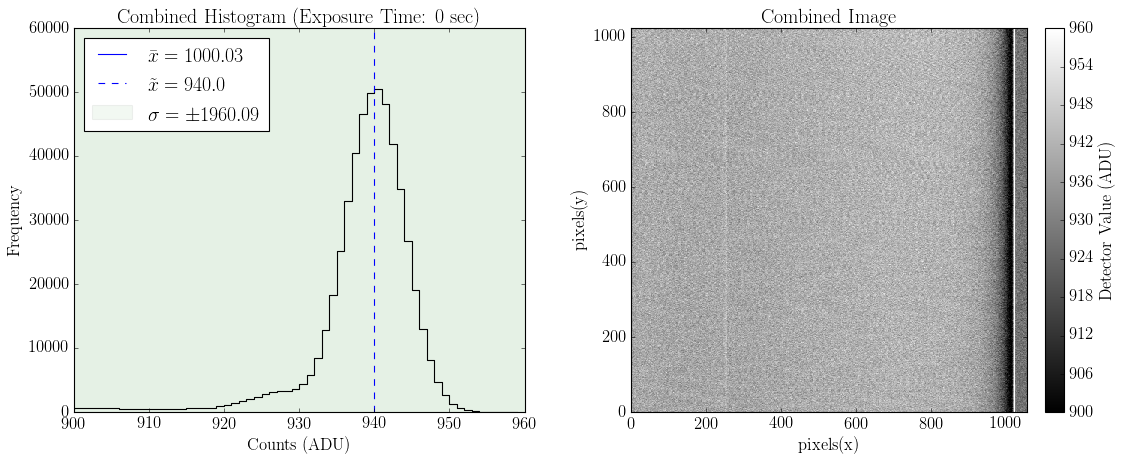

In [620]:
array3D = readData('data/exp0/')
bias_2D = combineFrame(array3D)
plotAll(bias_2D, rng=[900,960], hrng=[900,960], exp=0, save_dir='writeup/plots/')

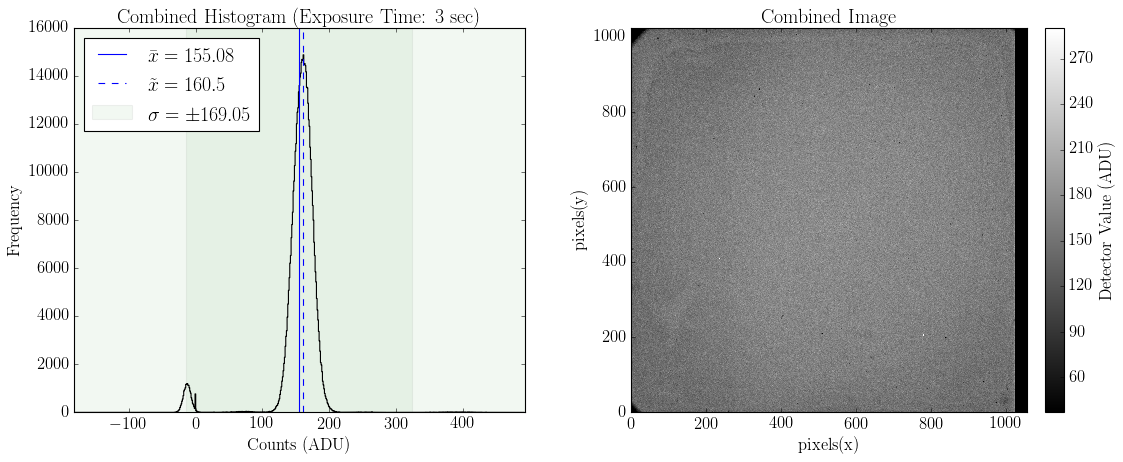

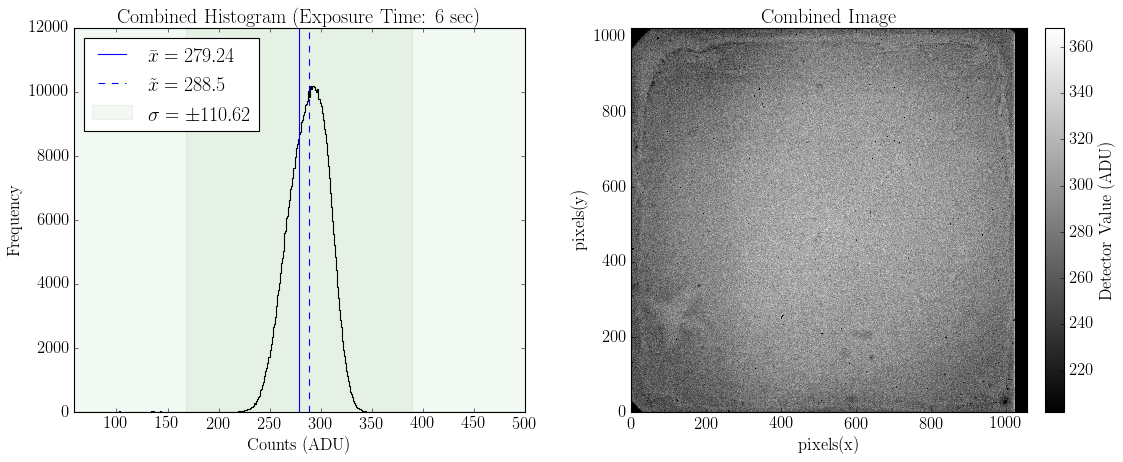

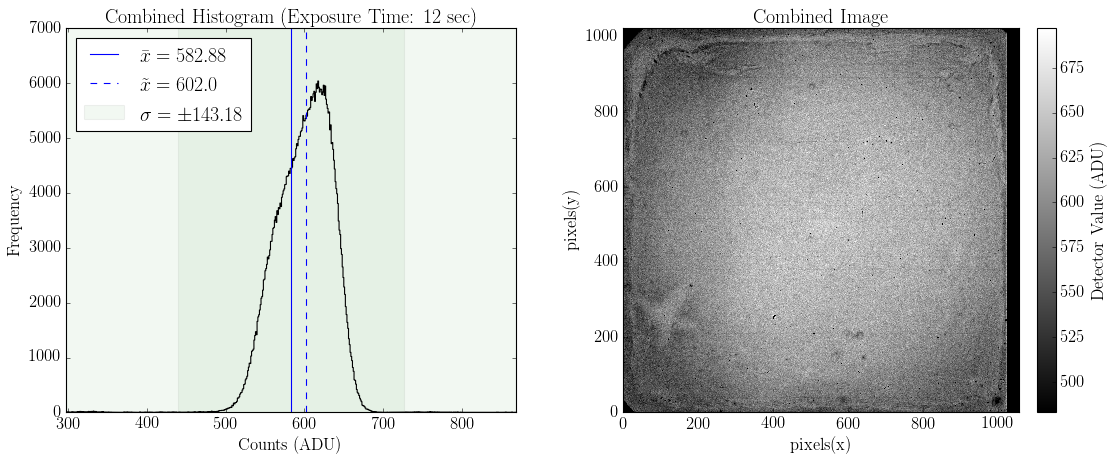

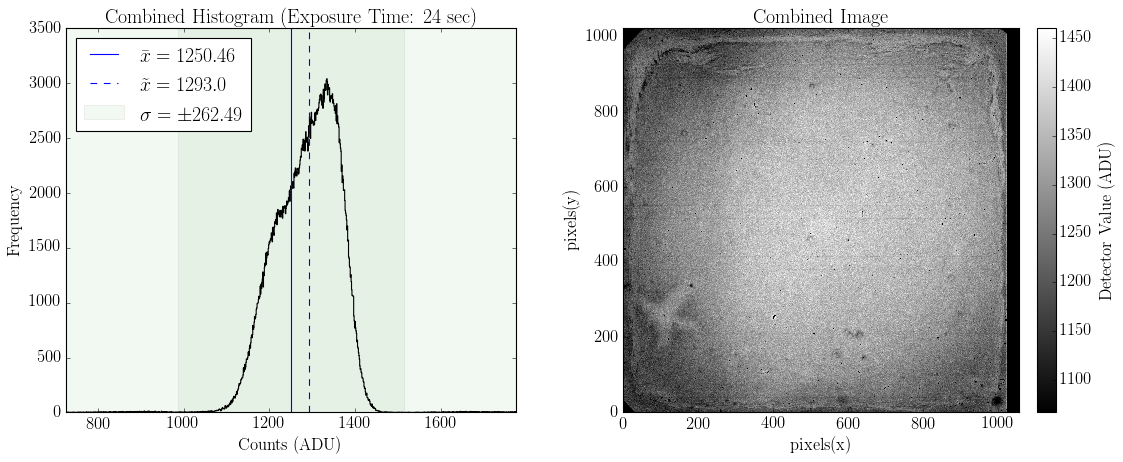

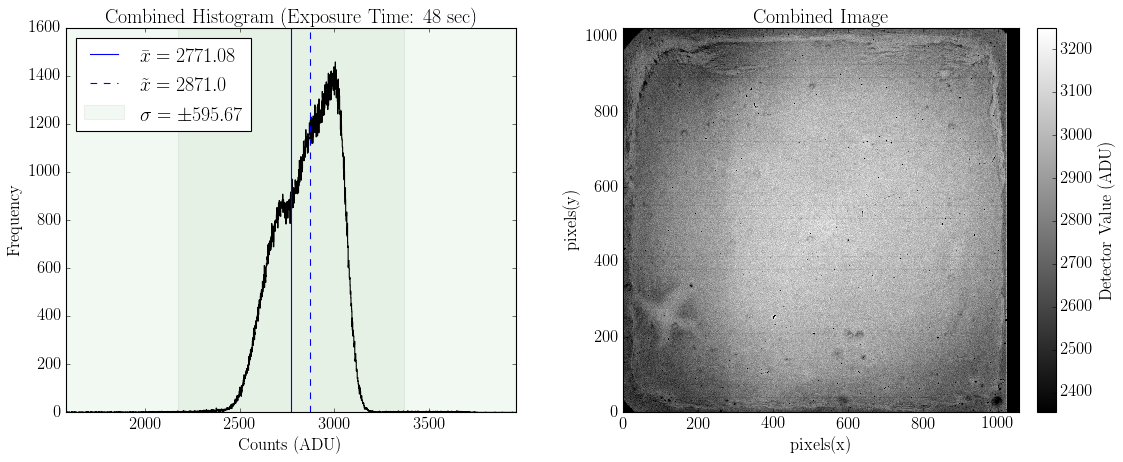

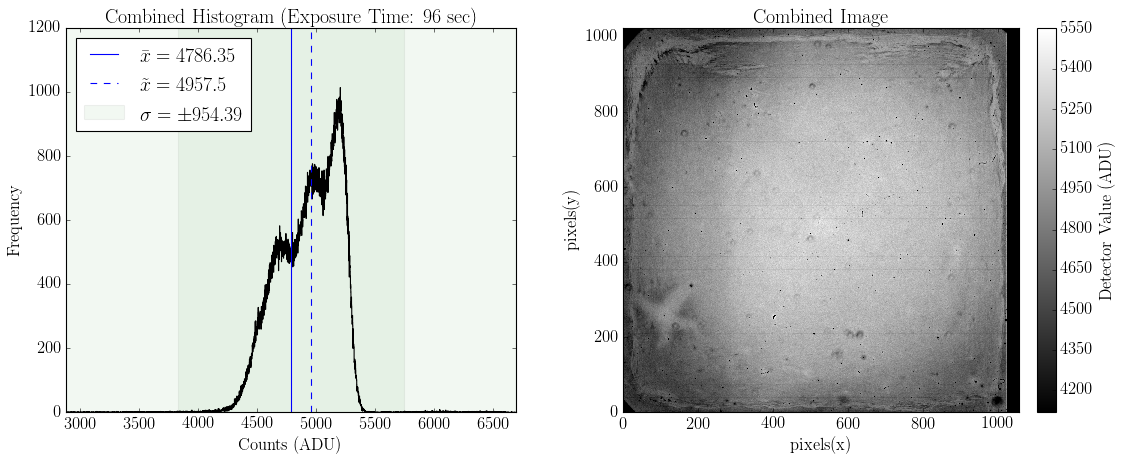

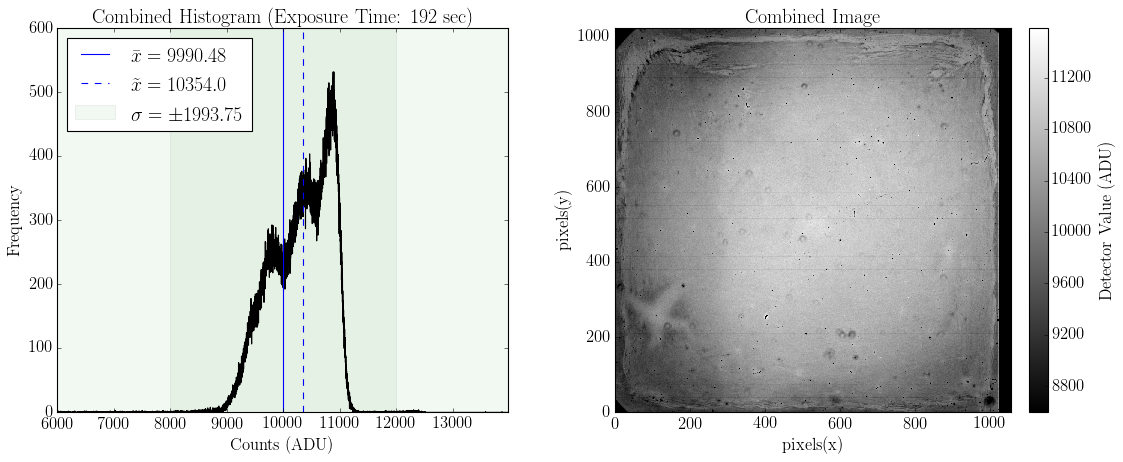

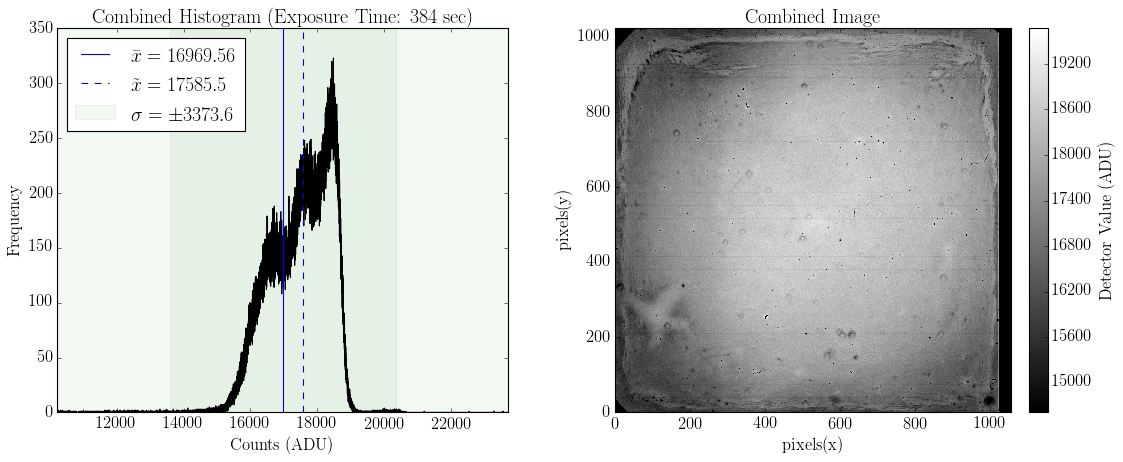

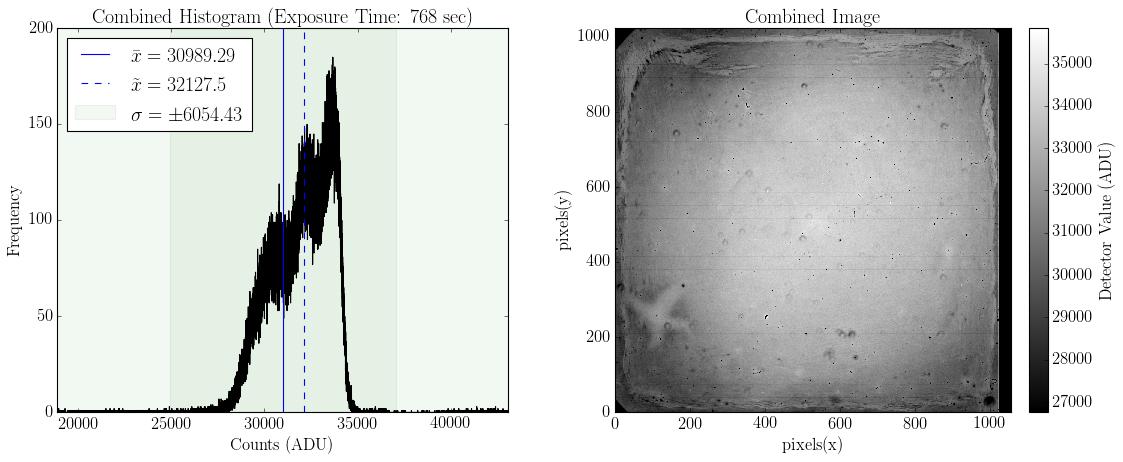

In [621]:
files = natsorted(os.listdir('data/'))[1:]
exp_times = np.array([int(f.split('exp')[1]) for f in files])

frames = []
for exp in exp_times:
    
    #Read frames, combine, and subtract combined bias frame
    array3D = readData('data/exp%s/'%(exp))
    array2D = combineFrame(array3D) - bias_2D
    
    frames.append(array2D.flatten())
    
    #Plot histogram and image & save to .png
    plotAll(array2D, sigma=2, exp=exp, save_dir='writeup/plots/')

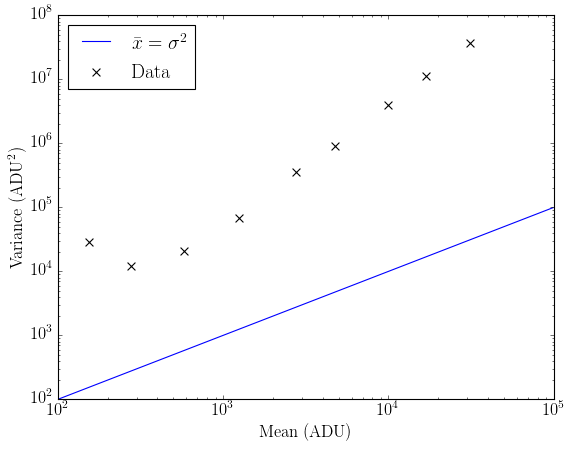

In [648]:
xbar = np.array([np.mean(f) for f in frames])
s = np.array([np.std(f) for f in frames])

xyline = np.arange(10**2, 10**5, 10**3)

plt.scatter(xbar, s**2, marker='x', s=50, color='k', label='Data')
plt.plot(xyline, xyline, label=r'$\bar{x}=\sigma^2$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**2, 10**5)
plt.ylim(10**2, 10**8)
plt.xlabel('Mean (ADU)')
plt.ylabel('Variance (ADU$^2$)')
plt.legend(loc='upper left', scatterpoints=1)
plt.savefig('writeup/plots/mean_vs_variance.png')
plt.show()

In [657]:
np.array(frames)

array([[-12.5,   1.5,  -5.5, ..., -15. , -23. ,  -9. ],
       [-12.5,  -9.5,  -5.5, ..., -32. , -42. , -32. ],
       [  6.5,  19.5,  12.5, ..., -14. , -18. , -12. ],
       ...,
       [291.5, 214.5, 305. , ..., -15. , -19. , -11.5],
       [491.5, 360.5, 451.5, ..., -22. , -30. , -10. ],
       [915.5, 630.5, 736.5, ...,  -1. , -15. ,   5. ]])

In [667]:
np.array([np.mean(f/exp_times[0]) for f in frames])

array([   51.69394676,    93.08012113,   194.2935885 ,   416.82150161,
         923.69466747,  1595.44952963,  3330.1587284 ,  5656.51834923,
       10329.76210484])